In [1]:
from tvb.simulator.models.oscillator import Generic2dOscillator
from tvb.simulator.integrators import HeunStochastic
from tvb.simulator.simulator import Simulator
from tvb.simulator.coupling import Linear
from tvb.simulator.monitors import Raw, TemporalAverage
from tvb.datatypes.connectivity import Connectivity

import matplotlib.pyplot as plt
import numpy as np
import torch
import math
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import arviz as az
from datetime import datetime
import pickle

%load_ext autoreload
%autoreload 2

/users/erichter/tvb/tvb-root/scientific_library/tvb/datatypes/surfaces.py:64: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [2]:
# Simulation parameters
a_sim = 2.0
b_sim = -10.0
c_sim = 0.0
d_sim = 0.02
I_sim = 0.0
nsig = 0.003
dt = 1.0
simulation_length = 1000

In [3]:
# Connectivity
connectivity = Connectivity()
connectivity.weights = np.array([[0., 2/3], [2/3, 0.]])
connectivity.region_labels = np.array(["R1", "R2"])
connectivity.centres = np.array([[0.1, 0.1, 0.1], [0.2, 0.1, 0.1]])
connectivity.tract_lengths = np.array([[0., 0.1], [0.1, 0.]])
connectivity.configure()

# Model
oscillator_model = Generic2dOscillator(
    a=np.asarray([a_sim]),
    b=np.asarray([b_sim]),
    c=np.asarray([c_sim]),
    d=np.asarray([d_sim]),
    I=np.asarray([I_sim]),
)
oscillator_model.configure()

# Integrator
integrator = HeunStochastic(dt=dt)
integrator.noise.nsig = np.array([nsig])
integrator.configure()

# Global coupling
coupling = Linear()

# Monitor
monitor = TemporalAverage()

In [4]:
# Simulator
sim = Simulator(
    model=oscillator_model,
    connectivity=connectivity,
    coupling=coupling,
    integrator=integrator,
    monitors=(monitor,),
    simulation_length=simulation_length
)

sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: 9a7938ff-4124-43a9-a235-14e6ebfa3ccd
coupling,Linear gid: e414c258-f255-441c-99e0-73dcae852cc1
gid,UUID('83cd8d57-5245-4268-9844-11bf9b5068f9')
initial_conditions,None
integrator,HeunStochastic gid: b8f593a0-e356-4ee0-882c-6cf6b89b02fc
model,Generic2dOscillator gid: 7261dffc-c30e-4523-8c78-f6f81267ceb3
monitors,"(,)"
simulation_length,1000.0


In [6]:
X = np.load("../limit-cycle_simulation.npy")

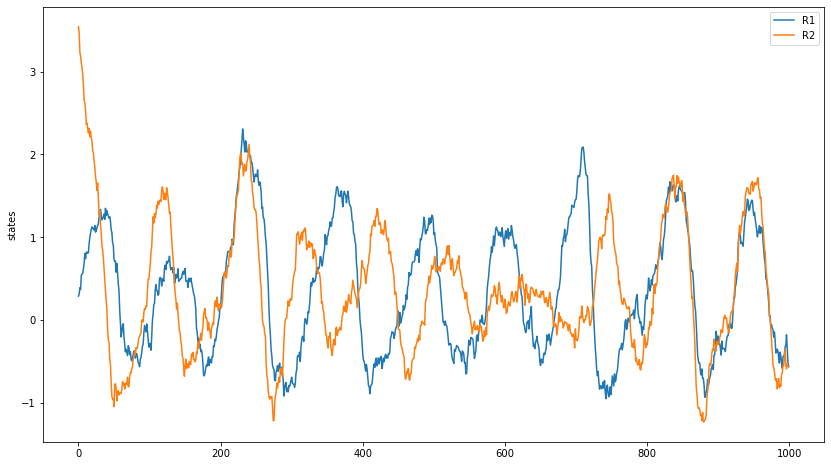

In [7]:
f1 = plt.figure(figsize=(14,8))
plt.plot(X[:, 0, 0, 0], label="R1")
plt.plot(X[:, 0, 1, 0], label="R2")
plt.ylabel("states")
plt.legend()
plt.show()

In [8]:
obs = X

#priors = {
#    "a": [1.8, 2.2, False],
#    "b": [-10.3, -9.7, False],
#    "c": [-0.1, 0.1, False],
#    "d": [0.01, 0.03, False],
#    "I": [-0.1, 0.1, False],
#    "epsilon": [0.0, 0.01, False]
#}

priors = {
    "a": [2.0, 0.1, False],
    "b": [-10, 0.1, False],
    "c": [0.0, 0.05, False],
    "d": [0.02, 0.005, False],
    "I": [0.0, 0.05, False],
    "epsilon": [0.0, 0.01, False]
}

shape = X.shape

In [9]:
from tvb.contrib.inversion.sbiInference import sbiModel

### SNPE inference

In [10]:
snpe_model = sbiModel(
    simulator_instance=sim,
    method="SNPE", 
    obs=obs, 
    prior_vars=priors,
    prior_dist="Normal",
    neural_net="mdn"
)

In [12]:
snpe_model.load("2022-07-29_1430_instance.pkl")

In [14]:
#snpe_model.run_inference(
#    num_simulations=1200, 
#    num_workers=4, 
#    num_samples=2000
#)

In [15]:
#inference_data = snpe_model.to_arviz_data(num_workers=4, save=True)

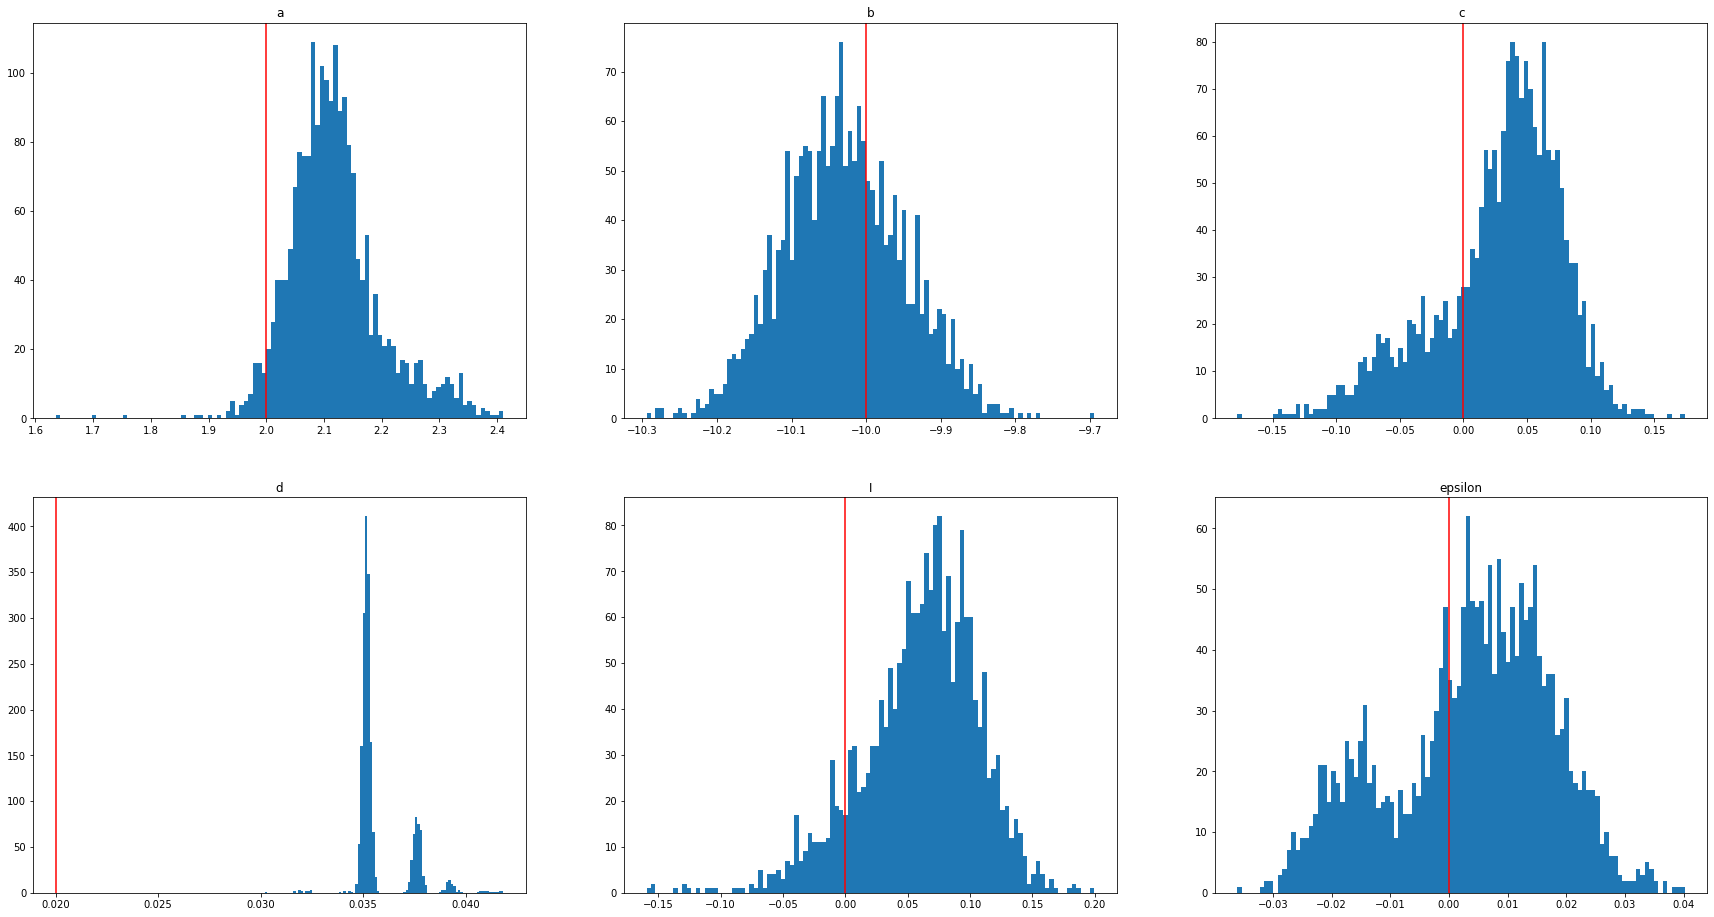

In [16]:
snpe_model.plot_posterior_samples(
    init_params={"a": a_sim, "b": b_sim, "c": c_sim, "d": d_sim, "I": I_sim, "epsilon": 0.0}
)

In [17]:
map_estimator = snpe_model.get_map_estimator()
map_estimator

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/users/erichter/anaconda3/envs/BrainSim-env/lib/python3.9/site-packages/pyknos/mdn/mdn.py:279: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  zero_mean_samples, _ = torch.triangular_solve(


tensor([ 2.1015e+00, -1.0051e+01,  4.9748e-02,  3.5159e-02,  7.5069e-02,
         8.1715e-03])

In [18]:
posterior_sample = snpe_model.get_sample()[0]
posterior_sample

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

tensor([  2.1184, -10.0293,   0.0564,   0.0353,   0.1006,   0.0217])

In [19]:
posterior_obs = snpe_model.simulation_wrapper(params=posterior_sample)
posterior_obs = posterior_obs.numpy().reshape(shape, order="F")

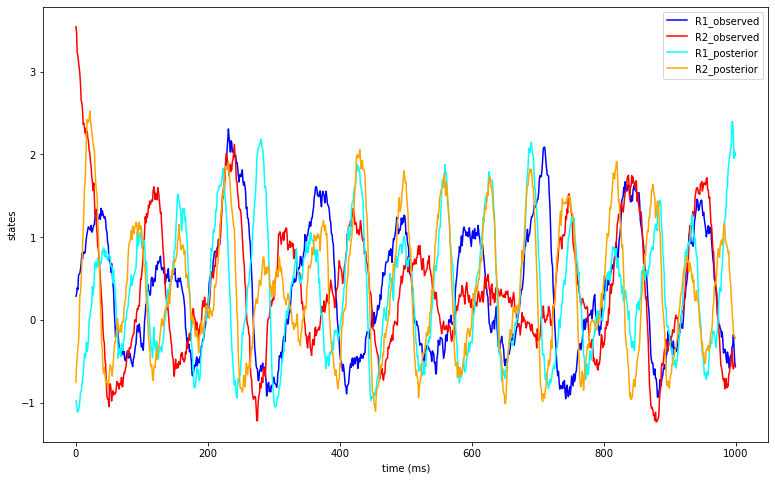

In [20]:
f3 = plt.figure(figsize=(13,8))
plt.plot(snpe_model.inference_data.observed_data.x_obs.values[:, 0, 0, 0], label="R1_observed", color="blue")
plt.plot(snpe_model.inference_data.observed_data.x_obs.values[:, 0, 1, 0], label="R2_observed", color="red")
plt.plot(posterior_obs[:, 0, 0, 0], label="R1_posterior", color="cyan")
plt.plot(posterior_obs[:, 0, 1, 0], label="R2_posterior", color="orange")
plt.legend()
plt.xlabel("time (ms)")
plt.ylabel("states")
plt.show()

In [21]:
snpe_model.information_criteria()

/users/erichter/anaconda3/envs/BrainSim-env/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/users/erichter/anaconda3/envs/BrainSim-env/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


{'WAIC': 6570.2855791023285, 'LOO': 4829.522625306621}

In [22]:
#snpe_model.save()

### SNLE inference

In [34]:
snle_model = sbiModel(
    simulator_instance=sim,
    method="SNLE", 
    obs=obs, 
    prior_vars=priors,
    prior_dist="Normal",
)

In [ ]:
snle_model.run_inference(
    num_simulations=800,
    num_workers=4,
    num_samples=2000
)

Running 800 simulations in 800 batches.:   0%|          | 0/800 [00:00<?, ?it/s]

/users/erichter/tvb/tvb-root/scientific_library/tvb/datatypes/surfaces.py:64: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)
/users/erichter/tvb/tvb-root/scientific_library/tvb/datatypes/surfaces.py:64: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)
/users/erichter/tvb/tvb-root/scientific_library/tvb/datatypes/surfaces.py:64: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)
/users/erichter/tvb/tvb-root/scientific_library/tvb/datatypes/surfaces.py:64: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


 Neural network successfully converged after 147 epochs.

Sample:   5%|██                                     | 1084/20011 [08:25,  2.79it/s, step size=1.18e-02, acc. prob=0.987]          

In [ ]:
inference_data = snle_model.to_arviz_data(save=True)

In [ ]:
snle_model.plot_posterior_samples(
    init_params={"a": a_sim, "b": b_sim, "c": c_sim, "d": d_sim, "I": I_sim, "epsilon": 0.0},
    bins=50
)

In [ ]:
map_estimator = snle_model.get_map_estimator()
map_estimator

In [ ]:
posterior_sample = snle_model.get_sample()[0]
posterior_sample

In [ ]:
posterior_obs = snle_model.simulation_wrapper(params=posterior_sample)
posterior_obs = posterior_obs.numpy().reshape(shape, order="F")

In [ ]:
f4 = plt.figure(figsize=(13,8))
plt.plot(snle_model.inference_data.observed_data.x_obs.values[:, 0, 0, 0], label="V_simulated", color="blue")
plt.plot(snle_model.inference_data.observed_data.x_obs.values[:, 1, 0, 0], label="W_simulated", color="red")
plt.plot(posterior_obs[:, 0, 0, 0], label="V_posterior", color="cyan")
plt.plot(posterior_obs[:, 1, 0, 0], label="W_posterior", color="orange")
plt.legend()
plt.xlabel("time (ms)")
plt.ylabel("states")
plt.show()

In [ ]:
snle_model.information_criteria()

### SNRE inference

In [ ]:
snre_model = sbiModel(
    integrator_instance=integrator, 
    model_instance=oscillator_model, 
    method="SNRE", 
    obs=obs, 
    priors=priors,
    obs_shape=shape
)

In [ ]:
snre_model.run_inference(
    num_simulations=800,
    num_workers=1,
    num_samples=2000
)

In [ ]:
inference_data = snre_model.to_arviz_data(save=True)

In [ ]:
snre_model.plot_posterior(
    init_params={"a": a_sim, "b": b_sim, "c": c_sim, "d": d_sim, "I": I_sim, "epsilon": 0.0}
)

In [ ]:
map_estimator = snre_model.get_map_estimator()
map_estimator

In [ ]:
posterior_sample = snre_model.get_sample()[0]
posterior_sample

In [ ]:
posterior_obs = snre_model.simulation_wrapper(params=map_estimator)
posterior_obs = posterior_obs.numpy().reshape(shape, order="F")

In [ ]:
f4 = plt.figure(figsize=(13,8))
plt.plot(snre_model.inference_data.observed_data.x_obs.values[:, 0, 0, 0], label="V_simulated", color="blue")
plt.plot(snre_model.inference_data.observed_data.x_obs.values[:, 1, 0, 0], label="W_simulated", color="red")
plt.plot(posterior_obs[:, 0, 0, 0], label="V_posterior", color="cyan")
plt.plot(posterior_obs[:, 1, 0, 0], label="W_posterior", color="orange")
plt.legend()
plt.xlabel("time (ms)")
plt.ylabel("states")
plt.show()

In [ ]:
snre_model.information_criteria()